# COMP0189 Applied AI Coursework 2
## Author: Henning Heyen (Student Number 22193699)


# Table of Contents

[1 Descriptive Statistics](#1)

[2 Machine Learning Pipeline](#2)

[2.1 Regularized Linear Model](#2.1)

[2.1.1 Liner Model Low Dimensional Data](#2.1.1)

[2.1.1 Liner Model High Dimensional Data](#2.1.2)

[2.2 Tree Model](#2.2)

[2.2.1 Tree Low Dimensional Data](#2.2.1)

[2.2.1 Tree High Dimensional Data](#2.2.2)

[2.3 Non Linear Model](#2.3)

[2.3.1 Non Liner Model Low Dimensional Data](#2.3.1)

[2.3.1 Non Liner Model High Dimensional Data](#2.3.2)

[3 Results](#3)

In [1]:
# Loading participants data
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Train participants
participants_train = pd.read_csv(os.path.join("data", "train_participants.csv" ))
participants_train["set"] = 'train'
participants_test = pd.read_csv(os.path.join("data", "test_participants.csv" ))

# Test participants
participants_test["set"] = 'test'

# All participants
participants = pd.concat([participants_train, participants_test])

<a id='1'></a>
## Descriptive Statistics

In [2]:
# Overview on the participants data
participants.head()

,participant_id,session,sex,age,diagnosis,study,site,TIV,CSF_Vol,GM_Vol,WM_Vol,set
0,CH7098a,V1,0.0,20.0,schizophrenia,SCHIZCONNECT-VIP,NU,1712.357084,375.529152,747.089338,586.391159,train
1,A00024535,V1,0.0,26.0,control,SCHIZCONNECT-VIP,MRN,1700.601735,399.493745,721.128411,579.446172,train
2,CC7563,V1,1.0,28.0,control,SCHIZCONNECT-VIP,WUSTL,1449.327365,220.825294,661.028439,566.500051,train
3,CC3945,V1,1.0,21.0,control,SCHIZCONNECT-VIP,WUSTL,1184.699000,201.579922,560.051329,423.016129,train
4,CH8853b,V1,1.0,21.0,control,SCHIZCONNECT-VIP,NU,1518.198466,291.544632,705.384606,520.807601,train


In [3]:
# Testing for missing values and data types
participants.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 513 entries, 0 to 102
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   participant_id  513 non-null    object 
 1   session         513 non-null    object 
 2   sex             513 non-null    float64
 3   age             513 non-null    float64
 4   diagnosis       513 non-null    object 
 5   study           513 non-null    object 
 6   site            513 non-null    object 
 7   TIV             513 non-null    float64
 8   CSF_Vol         513 non-null    float64
 9   GM_Vol          513 non-null    float64
 10  WM_Vol          513 non-null    float64
 11  set             513 non-null    object 
dtypes: float64(6), object(6)
memory usage: 52.1+ KB


In [4]:
# Printing train and test sizes
print(f'Number of train participants: {participants_train.shape[0]}')
print(f'Number of test participants: {participants_test.shape[0]}')

Number of train participants: 410
Number of test participants: 103


         age                                                    
       count       mean        std   min   25%   50%   75%   max
set                                                             
test   103.0  33.466019  12.809935  14.0  23.5  31.0  41.0  66.0
train  410.0  33.068293  12.562225  15.0  22.0  29.0  43.0  65.0
           age
set   sex     
test  0.0   65
      1.0   38
train 0.0  257
      1.0  153


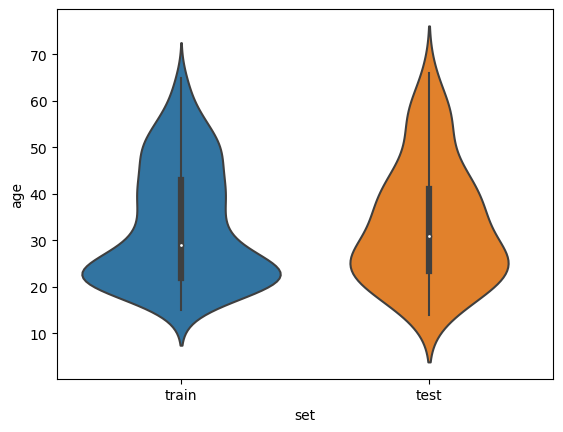

In [5]:
# Understanding sex and age distribution 
sns.violinplot(x="set", y="age", data=participants)
print(participants[["age", "set"]].groupby("set").describe())
print(participants[["set", "sex", "age"]].groupby(["set", "sex"]).count())

In [6]:
# Distribution of the target variable
participants.value_counts("diagnosis")

diagnosis
control          277
schizophrenia    236
dtype: int64

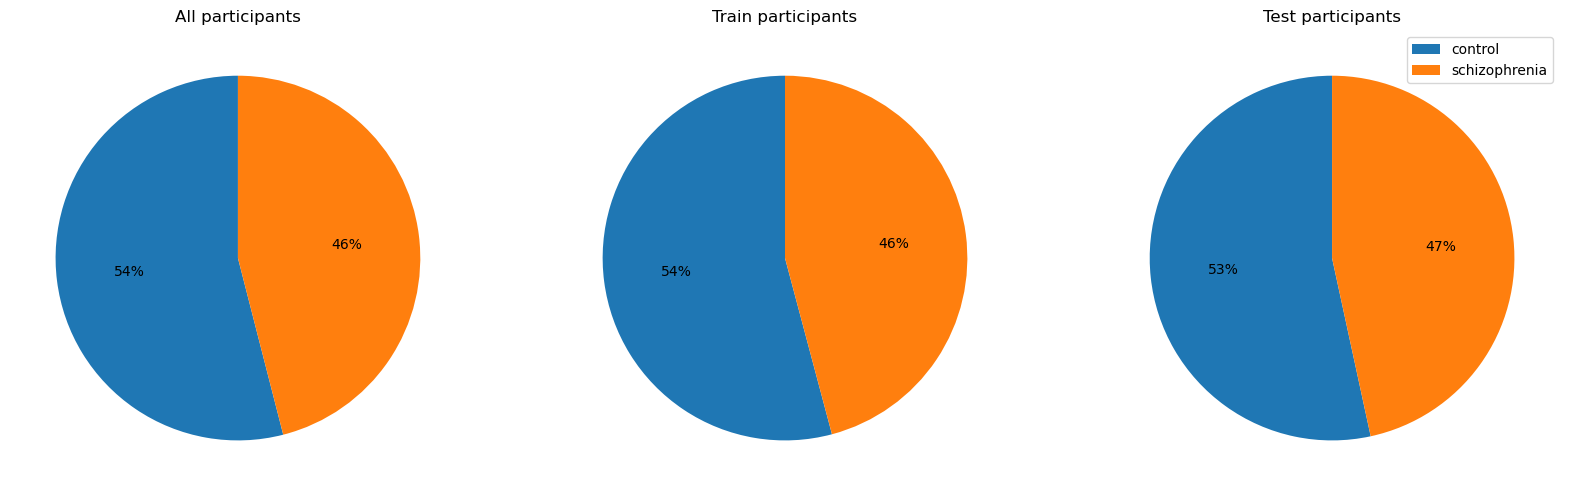

In [7]:
# Distribution of the target variable across train and test data. Verifying same distributions
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(131)
ax1.pie(participants.value_counts("diagnosis"), autopct='%.0f%%', startangle = 90)
ax1.set_title('All participants')
ax2 = fig.add_subplot(132)
ax2.pie(participants_train.value_counts("diagnosis"), autopct='%.0f%%', startangle = 90)
ax2.set_title('Train participants')
ax3 = fig.add_subplot(133)
ax3.pie(participants_test.value_counts("diagnosis"), autopct='%.0f%%', startangle = 90)
ax3.set_title('Test participants')

plt.legend(labels=['control','schizophrenia'], loc=0)
plt.show()

In [8]:
# Distribution of sex
participants.value_counts("sex")

sex
0.0    322
1.0    191
dtype: int64

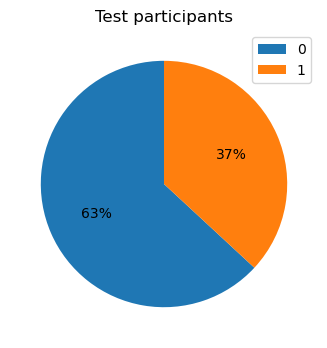

In [9]:
# Distribution of gender. Showing the imbalance
plt.figure(figsize=(8,4))
plt.pie(participants_test.value_counts("sex"), autopct='%.0f%%', startangle = 90)
plt.title('Test participants')

plt.legend(labels=[0,1], loc=0)
plt.show()

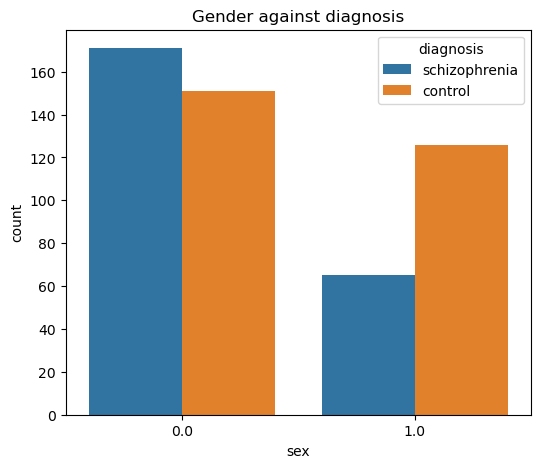

In [10]:
# Plotting gender against diagnosis. 
plt.figure(figsize=(6,5))
sns.countplot(data=participants, x='sex', hue='diagnosis')
plt.title('Gender against diagnosis')
plt.show()

<a id='2'></a>
# Machine Learning Pipeline

In [11]:
# all imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.preprocessing as preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold, GridSearchCV, cross_validate
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, roc_curve
from lightgbm import LGBMClassifier

import problem


In [12]:
# Loading train and test data:
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

assert X_train.shape[1] == 284 + 331695

**Feature extractor of ROIs or voxels within the brain (VBM)**

Selecting only rois or vbm images:

This can be achieved by a `ROIsFeatureExtractor` or `VBMFeatureExtractor` 

In [13]:
# X[:, :284] refers to the ROI data
class ROIsFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, :284]
    
# X[:, 284:] refers to the VBM data
class VBMFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs featsures:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, 284:]

# Printing the X_train shape for ROI
fe = ROIsFeatureExtractor()
print(fe.transform(X_train).shape)

# Printing the X_train shape for VBM
fe = VBMFeatureExtractor()
print(fe.transform(X_train).shape)

(410, 284)
(410, 331695)


In [14]:
def get_clf(model, data):
    '''
    returns a pipeline estimator based on the model and the data modality
    @params
        model: (String) can be 'linear', 'tree' or 'nonlinear' corresponding to the three selected models(Logistic Regression, Random Forest, Multi-Layer-Perceptron)
        data: (String) can be 'ROI' or 'VBM' corresponging to the high or low dimensional data
    @returns
        (pipeline): pipeline object that can be trained. 
    '''
    # Setting the feature extractor
    if data == 'ROI':
        extractor = ROIsFeatureExtractor()
    elif data == 'VBM':
        extractor = VBMFeatureExtractor()
    else:
        print("data must be 'ROI' or 'VBM'")
        return

    # Setting the model
    if model == 'linear':
        clf = LogisticRegression(max_iter=1000)
    elif model == 'tree':
        clf = RandomForestClassifier()
    elif model == 'nonlinear':    
        #clf = SVC()
        clf = MLPClassifier()
    else:
        print("model must be 'linear', 'tree' or 'nonlinear'")
        return
    
    # Setting scaling technique
    scaler = StandardScaler()

    # setup pipeline
    pipe = make_pipeline(
    extractor,
    scaler,
    clf,
    )

    return pipe

In [15]:
def tune(clf, param_grid, verbose=True, cv_strategy='StratifiedKFold', final_scoring='roc_auc', n_splits=5):
    '''
        method performs crossvalidation and hyperparametr tuning on the train data
        @params
            clf: (pipeline) ideally the classifier returned by the get_clf() method
            param_grid: (dict) dictionary containing hyperparameter to be tested in gridsearch
            verbose: (Bool) prints Best hyperparameters, Mean score for roc_auc and balanced_accuracy if set to True 
            cv_strategy: (String) can be 'StratifiedKFold' or 'StratifiedGroupKFold'
            final_scoring: (String) can be 'roc_auc' or 'balanced_accuracy'. Used for final model selection
            n_splits: (int) defining the number of folds for StratifiedKFold. for StratifiedGroupKFold n_split is set to 2 becuase group is fixed on gender (0 and 1 group)
        @returns
            results: (dict) dictionary containing 'mean_roc_auc', 'std_roc_auc', 'mean_bacc', 'std_bacc', 'mean_fit_time', 'std_fit_time'

    '''

    # Define the cross-validation method
    if cv_strategy == 'StratifiedKFold':
        cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
    elif cv_strategy == 'StratifiedGroupKFold':
        # For Group CV the number of folds must be less or equal to the number of groups to ensure that groups can be separated
        cv = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=0)
    else:
        print("cv_strategy must be 'StratifiedKFold' or 'StratifiedGroupKFold'")
        return

    # Define the grid search object
    grid_search = GridSearchCV(
        clf,
        param_grid,
        cv=cv,
        scoring=['balanced_accuracy', 'roc_auc'], 
        refit=final_scoring,
        n_jobs=-1
    )

    # Fit the grid search object to the data using StratifiedKFold
    if cv_strategy == 'StratifiedKFold':
        grid_search.fit(X_train, y_train)
        
    # Fit the grid search object to the data using StratifiedGroupKFold
    elif cv_strategy == 'StratifiedGroupKFold':
        sex = participants_train['sex'].values
        grid_search.fit(X_train, y_train, groups=sex)

    #Results
    mean_roc_auc = round(grid_search.cv_results_['mean_test_roc_auc'][grid_search.best_index_],3)
    std_roc_auc = round(grid_search.cv_results_['std_test_roc_auc'][grid_search.best_index_],3)
    mean_bacc = round(grid_search.cv_results_['mean_test_balanced_accuracy'][grid_search.best_index_],3)
    std_bacc = round(grid_search.cv_results_['std_test_balanced_accuracy'][grid_search.best_index_],3)
    mean_fit_time = round(grid_search.cv_results_['mean_fit_time'][grid_search.best_index_],1)
    std_fit_time = round(grid_search.cv_results_['std_fit_time'][grid_search.best_index_],1)

    results = {
        'mean_roc_auc': mean_roc_auc,
        'std_roc_auc': std_roc_auc,
        'mean_bacc': mean_bacc,
        'std_bacc': std_bacc,
        'mean_fit_time': mean_fit_time,
        'std_fit_time': std_fit_time,
    }
    
    # printing results
    if verbose:
        # Print the best hyperparameters and balanced_accuracy and roc_auc scores
        print("Best hyperparameters:", grid_search.best_params_)
        print("Mean score for roc_auc :", mean_roc_auc)
        print("Mean score for balanced_accuracy:", mean_bacc, '\n')

    return results 

In [16]:
def evaluate(clf_best, report_fit_time=False):
    '''
        trains the best model on the train data and evaluates on the test data
        @params:
            clf_best: (pipeline) best clasiifier. 
            report_fit_time: (Bool) prints the time to fit the train data if set to True (default is False)
        @returns
            (dict): results containing bacc_train, auc_train, bacc_test, auc_test, fpr (false positive rate) and tpr (true positive rate)
    '''
    # Refit on all train
    if report_fit_time:
        %time clf_best.fit(X_train, y_train)
    else:
        clf_best.fit(X_train, y_train)

    # Apply on test
    y_pred_train = clf_best.predict(X_train)
    y_pred_test = clf_best.predict(X_test)
    score_pred_test = clf_best.predict_proba(X_test)[:, 1]
    score_pred_train = clf_best.predict_proba(X_train)[:, 1]

    bacc_train = round(balanced_accuracy_score(y_train, y_pred_train),3)
    auc_train = round(roc_auc_score(y_train, score_pred_train),3)

    bacc_test = round(balanced_accuracy_score(y_test, y_pred_test),3)
    auc_test = round(roc_auc_score(y_test, score_pred_test),3)

    fpr, tpr, _ = roc_curve(y_test, score_pred_test, pos_label='schizophrenia')

    print("# Train")
    print('bACC=%.2f' % bacc_train,
        'ROC-AUC=%.2f' % auc_train, '\n')

    print("# Test")
    print('bACC=%.2f' % bacc_test,
        'ROC-AUC=%.2f' % auc_test, '\n')
    

    return {
        'bacc_train': bacc_train,
        'auc_train': auc_train,
        'bacc_test': bacc_test,
        'auc_test': auc_test,
        'fpr':fpr,
        'tpr':tpr,   
    }

<a id='2.1'></a>
## Regularized Linear Model


<a id='2.1.1'></a>

### Liner Model Low Dimensional Data

In [46]:
clf_linear_low = get_clf(model='linear', data='ROI')

# Define the hyperparameters to tune
param_grid_linear = {
    'logisticregression__C': [0.1, 0.3, 0.5, 0.7, 1],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear'],
    'logisticregression__max_iter': [10000],
    'logisticregression__random_state': [42],
}

print('LogisticRegression StratifiedKFold (ROI): ')
train_results_linear_low_skf = tune(clf_linear_low, param_grid_linear, cv_strategy='StratifiedKFold')

print('LogisticRegression StratifiedGroupKFold (ROI): ')
train_results_linear_low_sgkf = tune(clf_linear_low, param_grid_linear, cv_strategy='StratifiedGroupKFold')

print('results_linear_low_skf: ', train_results_linear_low_skf)
print('results_linear_low_sgkf: ', train_results_linear_low_sgkf)

LogisticRegression StratifiedKFold (ROI): 
Best hyperparameters: {'logisticregression__C': 0.1, 'logisticregression__max_iter': 10000, 'logisticregression__penalty': 'l1', 'logisticregression__random_state': 42, 'logisticregression__solver': 'liblinear'}
Mean score for roc_auc : 0.823
Mean score for balanced_accuracy: 0.757 

LogisticRegression StratifiedGroupKFold (ROI): 
Best hyperparameters: {'logisticregression__C': 0.3, 'logisticregression__max_iter': 10000, 'logisticregression__penalty': 'l1', 'logisticregression__random_state': 42, 'logisticregression__solver': 'liblinear'}
Mean score for roc_auc : 0.793
Mean score for balanced_accuracy: 0.699 

results_linear_low_skf:  {'mean_roc_auc': 0.823, 'std_roc_auc': 0.047, 'mean_bacc': 0.757, 'std_bacc': 0.06, 'mean_fit_time': 9.5, 'std_fit_time': 0.1}
results_linear_low_sgkf:  {'mean_roc_auc': 0.793, 'std_roc_auc': 0.034, 'mean_bacc': 0.699, 'std_bacc': 0.009, 'mean_fit_time': 8.9, 'std_fit_time': 0.0}


In [47]:
# Best linear model for the ROI data using StratifiedKFold
clf_linear_best_low_skf = make_pipeline(
    ROIsFeatureExtractor(),
    StandardScaler(),
    LogisticRegression( 
                       C=0.1,
                       max_iter=10000,                
                       penalty='l1', 
                       solver= 'liblinear',
                       random_state=42,
                       )
)

# Best linear model for the ROI data using StratifiedGroupKFold
clf_linear_best_low_sgkf = make_pipeline(
    ROIsFeatureExtractor(),
    StandardScaler(),
    LogisticRegression( 
                       C=0.3,
                       max_iter=10000,
                       penalty='l1', 
                       solver= 'liblinear',
                       random_state=42,
                       )
)

print('Evaluation of LogisticRegression StratifiedKFold (ROI): ')
test_results_linear_low_skf = evaluate(clf_linear_best_low_skf)

print('Evaluation of LogisticRegression StratifiedGroupKFold (ROI): ')
test_results_linear_low_sgkf = evaluate(clf_linear_best_low_sgkf)


Evaluation of LogisticRegression StratifiedKFold (ROI): 
# Train
bACC=0.80 ROC-AUC=0.88 

# Test
bACC=0.78 ROC-AUC=0.84 

Evaluation of LogisticRegression StratifiedGroupKFold (ROI): 
# Train
bACC=0.83 ROC-AUC=0.93 

# Test
bACC=0.78 ROC-AUC=0.85 



<a id='2.1.2'></a>
### Liner Model High Dimensional Data

In [19]:
# Best linear model for the VBM data
clf_linear_best_high = make_pipeline(
    VBMFeatureExtractor(),
    StandardScaler(),
    LogisticRegression( 

    )
)

print('Evaluation of LogisticRegression (VBM): ')
test_results_linear_high = evaluate(clf_linear_best_high, report_fit_time=True)



Evaluation of LogisticRegression (VBM): 
CPU times: user 44.6 s, sys: 6.83 s, total: 51.4 s
Wall time: 13.7 s
# Train
bACC=1.00 ROC-AUC=1.00 

# Test
bACC=0.72 ROC-AUC=0.81 



<a id='2.2'></a>
## Tree model

<a id='2.2.1'></a>
### Tree Model Low Dimensional Data

In [38]:
clf_tree_low = get_clf(model='tree', data='ROI')

# Define the hyperparameters to tune
param_grid_tree = {
    "randomforestclassifier__min_samples_split": [2, 5],
    "randomforestclassifier__n_estimators": [100, 300],
    "randomforestclassifier__max_depth": [2, 3, 5],
    "randomforestclassifier__random_state": [42],
    "randomforestclassifier__n_jobs": [-1],
}

print('RandomForestClassifier StratifiedKFold (ROI): ')
%time train_results_tree_low_skf = tune(clf_tree_low, param_grid_tree, cv_strategy='StratifiedKFold')

print('RandomForestClassifier StratifiedGroupKFold (ROI): ')
%time  train_results_tree_low_sgkf = tune(clf_tree_low, param_grid_tree, cv_strategy='StratifiedGroupKFold')

print('results_tree_low_skf: ', train_results_tree_low_skf)
print('results_tree_low_sgkf: ', train_results_tree_low_sgkf)

RandomForestClassifier StratifiedKFold (ROI): 
Best hyperparameters: {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__n_jobs': -1, 'randomforestclassifier__random_state': 42}
Mean score for roc_auc : 0.786
Mean score for balanced_accuracy: 0.716 

CPU times: user 1.53 s, sys: 1.27 s, total: 2.81 s
Wall time: 1min 7s
RandomForestClassifier StratifiedGroupKFold (ROI): 
Best hyperparameters: {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__n_jobs': -1, 'randomforestclassifier__random_state': 42}
Mean score for roc_auc : 0.78
Mean score for balanced_accuracy: 0.697 

CPU times: user 1.05 s, sys: 1.01 s, total: 2.07 s
Wall time: 33.1 s
results_tree_low_skf:  {'mean_roc_auc': 0.786, 'std_roc_auc': 0.058, 'mean_bacc': 0.716, 'std_bacc': 0.065, 'mean_fit_time': 7.9, 'std_fit_ti

In [39]:
# Best tree model for the ROI data using StratifiedKFold
clf_tree_best_low_skf = make_pipeline(
    ROIsFeatureExtractor(),
    StandardScaler(),
    RandomForestClassifier(
        max_depth=5,
        min_samples_split=2,
        n_estimators=300,
        n_jobs=-1,
        random_state=42,
    )
)

# Best tree model for the ROI data using StratifiedGroupKFold
clf_tree_best_low_sgkf = make_pipeline(
    ROIsFeatureExtractor(),
    StandardScaler(),
    RandomForestClassifier(
        max_depth=5,
        min_samples_split=5,
        n_estimators=300,
        n_jobs=-1,
        random_state=42,
    )
)

print('Evaluation of RandomForestClassifier StratifiedKFold (ROI): ')
%time test_results_tree_low_skf = evaluate(clf_tree_best_low_skf)

print('Evaluation of RandomForestClassifier StratifiedGroupKFold (ROI): ')
%time test_results_tree_low_sgkf = evaluate(clf_tree_best_low_sgkf)


Evaluation of RandomForestClassifier StratifiedKFold (ROI): 
# Train
bACC=0.95 ROC-AUC=1.00 

# Test
bACC=0.76 ROC-AUC=0.80 

CPU times: user 972 ms, sys: 165 ms, total: 1.14 s
Wall time: 548 ms
Evaluation of RandomForestClassifier StratifiedGroupKFold (ROI): 
# Train
bACC=0.95 ROC-AUC=0.99 

# Test
bACC=0.75 ROC-AUC=0.80 

CPU times: user 953 ms, sys: 151 ms, total: 1.1 s
Wall time: 512 ms


<a id='2.2.2'></a>
### Tree Model High Dimensional Data

In [22]:
# Best tree model for the VBM data
clf_tree_best_high = make_pipeline(
    VBMFeatureExtractor(),
    StandardScaler(),
    RandomForestClassifier(
        random_state=42,    
    )
)

print('Evaluation of GradientBoostingClassifier (VBM): ')
test_results_tree_high = evaluate(clf_tree_best_high, report_fit_time=True)


Evaluation of GradientBoostingClassifier (VBM): 
CPU times: user 6.82 s, sys: 1.26 s, total: 8.08 s
Wall time: 10.4 s
# Train
bACC=1.00 ROC-AUC=1.00 

# Test
bACC=0.61 ROC-AUC=0.71 



<a id='2.3'></a>
## Non Linear Model

<a id='2.3.1'></a>
### Non Linear Model Low Dimensional Data

In [23]:
clf_nonlinear_low = get_clf(model='nonlinear', data='ROI')

# Define the hyperparameters to tune
param_grid_nonlinear = {
    'mlpclassifier__hidden_layer_sizes': [(50,), (100,), (100, 100)],
    'mlpclassifier__activation': ['relu', 'logistic'],
    'mlpclassifier__solver': ['adam', 'sgd'],
    'mlpclassifier__learning_rate': ['constant', 'adaptive'],
    'mlpclassifier__max_iter': [10000],
    'mlpclassifier__random_state': [42],
}

print('MLPClassifier StratifiedKFold (ROI): ')
%time train_results_nonlinear_low_skf = tune(clf_nonlinear_low, param_grid_nonlinear, cv_strategy='StratifiedKFold')

print('MLPClassifier StratifiedGroupKFold (ROI): ')
%time train_results_nonlinear_low_sgkf = tune(clf_nonlinear_low, param_grid_nonlinear, cv_strategy='StratifiedGroupKFold')

print('results_nonlinear_low_skf: ', train_results_nonlinear_low_skf)
print('results_nonlinear_low_sgkf: ', train_results_nonlinear_low_sgkf)

MLPClassifier StratifiedKFold (ROI): 
Best hyperparameters: {'mlpclassifier__activation': 'logistic', 'mlpclassifier__hidden_layer_sizes': (100,), 'mlpclassifier__learning_rate': 'adaptive', 'mlpclassifier__max_iter': 10000, 'mlpclassifier__random_state': 42, 'mlpclassifier__solver': 'sgd'}
Mean score for roc_auc : 0.823
Mean score for balanced_accuracy: 0.718 

CPU times: user 22.2 s, sys: 8.28 s, total: 30.5 s
Wall time: 3min 29s
MLPClassifier StratifiedGroupKFold (ROI): 
Best hyperparameters: {'mlpclassifier__activation': 'relu', 'mlpclassifier__hidden_layer_sizes': (100,), 'mlpclassifier__learning_rate': 'constant', 'mlpclassifier__max_iter': 10000, 'mlpclassifier__random_state': 42, 'mlpclassifier__solver': 'adam'}
Mean score for roc_auc : 0.808
Mean score for balanced_accuracy: 0.706 

CPU times: user 7.17 s, sys: 3.12 s, total: 10.3 s
Wall time: 1min 13s
results_nonlinear_low_skf:  {'mean_roc_auc': 0.823, 'std_roc_auc': 0.033, 'mean_bacc': 0.718, 'std_bacc': 0.042, 'mean_fit_tim

In [24]:
# Best non linear model for the ROI data using StratifiedKFold
clf_nonlinear_best_low_skf = make_pipeline(
    ROIsFeatureExtractor(),
    StandardScaler(),
    MLPClassifier(
        activation='logistic',
        hidden_layer_sizes=(100,),
        max_iter=10000,
        random_state=42,
        solver='sgd',
        learning_rate='adaptive',
    )
)

# Best non linear model for the ROI data using StratifiedGroupKFold
clf_nonlinear_best_low_sgkf = make_pipeline(
    ROIsFeatureExtractor(),
    StandardScaler(),
    MLPClassifier(
        activation='relu',
        hidden_layer_sizes=(100,),
        max_iter=10000,
        random_state=42,
        solver='adam',
        learning_rate='constant',
    )
)

print('Evaluation of MLPClassifier StratifiedKFold (ROI): ')
%time test_results_nonlinear_low_skf = evaluate(clf_nonlinear_best_low_skf)

print('Evaluation of MLPClassifier StratifiedGroupKFold (ROI): ')
%time test_results_nonlinear_low_sgkf = evaluate(clf_nonlinear_best_low_sgkf)

Evaluation of MLPClassifier StratifiedKFold (ROI): 
# Train
bACC=0.82 ROC-AUC=0.91 

# Test
bACC=0.73 ROC-AUC=0.82 

CPU times: user 19.8 s, sys: 5.89 s, total: 25.7 s
Wall time: 4.01 s
Evaluation of MLPClassifier StratifiedGroupKFold (ROI): 
# Train
bACC=1.00 ROC-AUC=1.00 

# Test
bACC=0.78 ROC-AUC=0.83 

CPU times: user 5.78 s, sys: 1.96 s, total: 7.74 s
Wall time: 1.54 s


<a id='2.3.2'></a>
### Non Linear Model High Dimensional Data

In [25]:
# Best non linear model for the VBM data
clf_nonlinear_best_high = make_pipeline(
    VBMFeatureExtractor(),
    StandardScaler(),
    MLPClassifier(
        random_state=42,
    )
)

print('Evaluation of MLPClassifier (VBM): ')
test_results_nonlinear_high = evaluate(clf_nonlinear_best_high, report_fit_time=True)



Evaluation of MLPClassifier (VBM): 
CPU times: user 5min 14s, sys: 3min 52s, total: 9min 6s
Wall time: 4min 36s
# Train
bACC=1.00 ROC-AUC=1.00 

# Test
bACC=0.67 ROC-AUC=0.71 



<a id='3'></a>
# Results

In [26]:
# Preparing lists with results

# AUC_ROC information for RIO data
roc_data_low = [
    test_results_linear_low_skf,
    test_results_linear_low_sgkf,
    test_results_tree_low_skf,
    test_results_tree_low_sgkf,
    test_results_nonlinear_low_skf,
    test_results_nonlinear_low_sgkf,
]

# Defining the labels of ROC curves
roc_data_low_labels = [
    'LR (SKF)',
    'LR (SGKF)',
    'RF (SKF)',
    'RF (SGKF)',
    'MLP (SKF)',
    'MLP (SGKF)',
]

# Defining formatting the ROC curves
formats_low = ['b-','b--','r-','r--','g-','g--']

# AUC_ROC information for VBM data
roc_data_high = [
    test_results_linear_high,
    test_results_tree_high,
    test_results_nonlinear_high,
]

# Defining the labels of ROC curves
roc_data_high_labels = [
    'LR',
    'RF',
    'MLP',
]

# Defining formatting the ROC curves
formats_high = ['b-','r-','g-']


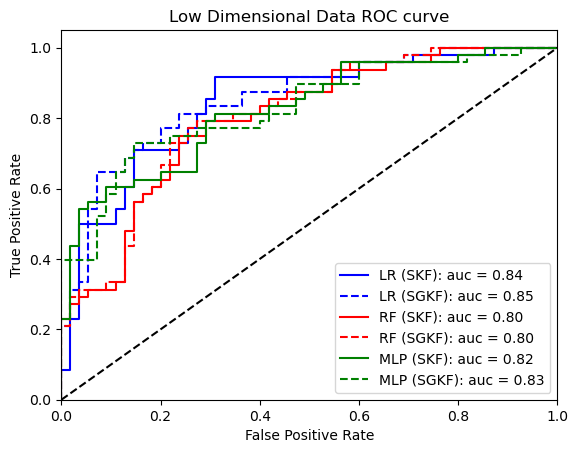

In [27]:
# Plotting the ROC curves of the models for the low dimensional data 
for roc_temp, name, format in zip(roc_data_low, roc_data_low_labels, formats_low):
    plt.plot(roc_temp['fpr'], roc_temp['tpr'], format, label=f'{name}: auc = %0.2f' % roc_temp['auc_test'])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Low Dimensional Data ROC curve')
plt.legend(loc="lower right")
#saving image
plt.savefig('roc_low.png')
plt.show()




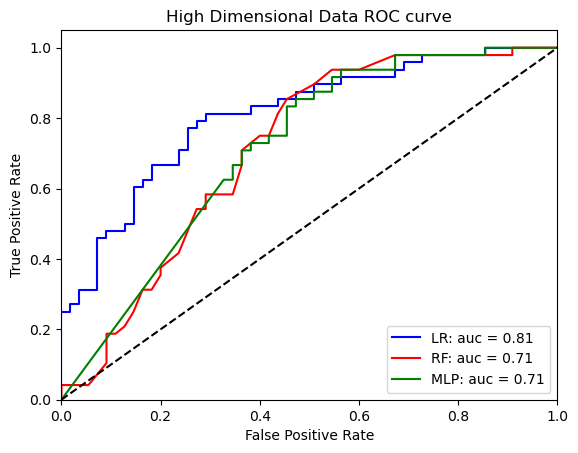

In [28]:
# Plotting the ROC curves of the models for the high dimensional data 
for roc_temp, name, format in zip(roc_data_high, roc_data_high_labels, formats_high):
    plt.plot(roc_temp['fpr'], roc_temp['tpr'], format, label=f'{name}: auc = %0.2f' % roc_temp['auc_test'])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('High Dimensional Data ROC curve')
plt.legend(loc="lower right")
#saving image
plt.savefig('roc_high.png')
plt.show()



In [29]:
# Loggoing the training time for the VBM data. See %time output
fit_time_high_linear = '13.7s'
fit_time_high_tree = '10.4s'
fit_time_high_nonlinear = '4min 36s'

In [48]:
# Combining train and test results

train_results_low_skf = [
    train_results_linear_low_skf,
    train_results_tree_low_skf,
    train_results_nonlinear_low_skf,
]

train_results_low_sgkf = [
    train_results_linear_low_sgkf,
    train_results_tree_low_sgkf,
    train_results_nonlinear_low_sgkf,
]

test_results_low_skf = [
    test_results_linear_low_skf,
    test_results_tree_low_skf,
    test_results_nonlinear_low_skf,
]

test_results_low_sgkf = [
    test_results_linear_low_sgkf,
    test_results_tree_low_sgkf,
    test_results_nonlinear_low_sgkf,
]

results_high = [
    test_results_linear_high,
    test_results_tree_high,
    test_results_nonlinear_high,
]

# Reported with the %time extension
fit_times_high = [fit_time_high_linear, fit_time_high_tree, fit_time_high_nonlinear]

model_names = ['LR', 'RF', 'MLP']

In [49]:
# Defining tables for results overview

# ROI data StratifiedKFold
df_low_skf = pd.DataFrame({
    'model': model_names,
    'test auc': [result['auc_test'] for result in test_results_low_skf],
    'test bacc': [result['bacc_test'] for result in test_results_low_skf], 
    'train auc': [result['auc_train'] for result in test_results_low_skf],
    'train bacc': [result['bacc_train'] for result in test_results_low_skf],
    'mean val auc': [f"{result['mean_roc_auc']} ({result['std_roc_auc']})" for result in train_results_low_skf],
    'mean val bacc': [result['mean_bacc'] for result in train_results_low_skf],
    'mean val bacc': [f"{result['mean_bacc']} ({result['std_bacc']})" for result in train_results_low_skf],
    'mean fit time': [f"{result['mean_fit_time']}s ({result['std_fit_time']}s)" for result in train_results_low_skf],
    })

# ROI data StratifiedGroupKFold
df_low_sgkf = pd.DataFrame({
    'model': model_names,
    'test auc': [result['auc_test'] for result in test_results_low_sgkf],
    'test bacc': [result['bacc_test'] for result in test_results_low_sgkf], 
    'train auc': [result['auc_train'] for result in test_results_low_sgkf],
    'train bacc': [result['bacc_train'] for result in test_results_low_sgkf],
    'mean val auc': [f"{result['mean_roc_auc']} ({result['std_roc_auc']})" for result in train_results_low_sgkf],
    'mean val bacc': [result['mean_bacc'] for result in train_results_low_sgkf],
    'mean val bacc': [f"{result['mean_bacc']} ({result['std_bacc']})" for result in train_results_low_sgkf],
    'mean fit time': [f"{result['mean_fit_time']}s ({result['std_fit_time']}s)" for result in train_results_low_sgkf],
    })

# VBM data
df_high = pd.DataFrame({
    'model': model_names,
    'test auc':[result['auc_test'] for result in results_high],
    'test bacc': [result['bacc_test'] for result in results_high],
    'train auc': [result['auc_train'] for result in results_high],
    'train bacc': [result['bacc_train'] for result in results_high],
    'fit time': fit_times_high,
    })

In [50]:
print('Results Low Dimensional Data StratifiedKFold')
df_low_skf

Results Low Dimensional Data StratifiedKFold


,model,test auc,test bacc,train auc,train bacc,mean val auc,mean val bacc,mean fit time
0,LR,0.844,0.781,0.882,0.801,0.823 (0.047),0.757 (0.06),9.5s (0.1s)
1,RF,0.798,0.757,0.996,0.951,0.786 (0.058),0.716 (0.065),7.9s (0.5s)
2,MLP,0.823,0.731,0.906,0.821,0.823 (0.033),0.718 (0.042),26.1s (0.9s)


In [51]:
print('Results Low Dimensional Data StratifiedGroupKFold')
df_low_sgkf

Results Low Dimensional Data StratifiedGroupKFold


,model,test auc,test bacc,train auc,train bacc,mean val auc,mean val bacc,mean fit time
0,LR,0.855,0.781,0.929,0.827,0.793 (0.034),0.699 (0.009),8.9s (0.0s)
1,RF,0.804,0.748,0.995,0.951,0.78 (0.089),0.697 (0.077),7.7s (0.2s)
2,MLP,0.827,0.781,1.000,1.000,0.808 (0.048),0.706 (0.035),8.8s (0.2s)


In [52]:
df_high

,model,test auc,test bacc,train auc,train bacc,fit time
0,LR,0.809,0.719,1.0,1.0,13.7s
1,RF,0.712,0.612,1.0,1.0,10.4s
2,MLP,0.713,0.669,1.0,1.0,4min 36s


In [53]:
#save to CSV
df_low_skf.to_csv('df_low_skf.csv')
df_low_sgkf.to_csv('df_low_sgkf.csv')
df_high.to_csv('df_high.csv')